# Portfolio optimization : Markowitz's Mean-Variance Optimization technique using Python_Pyportfolioopt library

## Introduction :

In this work, we have conducted portfolio optimization using the mean-variance optimization technique implemented through the powerful pyportfolioopt library in **Python**. 

Mean-variance optimization is based on **Harry Markowitz**’s 1952 classic paper, which spearheaded the transformation of portfolio management from an art into a science. The key insight is that by combining assets with different expected returns and volatilities, one can decide on a mathematically optimal allocation.

The primary objective of this work was to construct and analyze three distinct portfolios with varying optimization goals.

- The first portfolio aimed to minimize volatility, emphasizing stability and capital preservation. 
- The second portfolio, unconstrained in its approach, focused on maximizing the Sharpe ratio, which balances risk and reward.
- Finally, the third portfolio incorporated L2 regularization as a constraint, striving to strike a balance between risk management and performance optimization.

To evaluate the effectiveness of these portfolios, we plotted the efficient frontier, which represents the set of portfolios that offer the highest expected return for each level of risk. This visualization provides valuable insights into the risk-return trade-offs and allows for a comprehensive comparison of the three optimized portfolios.

By leveraging pyportfolioopt's mean-variance optimization capabilities, we were able to construct portfolios that align with different investment objectives and risk preferences.

The analysis and comparison of these three portfolios on the efficient frontier enable us to understand the impact of different optimization strategies on risk, return, and the overall portfolio composition.

#### Import libraries :

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import expected_returns, risk_models
from pypfopt.risk_models import sample_cov
from pypfopt import plotting
from pypfopt.objective_functions import L2_reg

import warnings
warnings.filterwarnings('ignore')

#### Importing financial data

The financial data used corresponds to 10 US companies operating in different sectors :

- Apple Inc. (AAPL) - Technology sector
- Johnson & Johnson (JNJ) - Healthcare sector
- Procter & Gamble Co. (PG) - Consumer goods sector
- JPMorgan Chase & Co. (JPM) - Financial sector
- Exxon Mobil Corporation (XOM) - Oil and gas sector
- Amazon.com Inc. (AMZN) - E-commerce/Technology sector
- Coca-Cola Company (KO) - Beverage sector
- Microsoft Corporation (MSFT) - Technology sector
- Barrick Gold Corporation (GOLD) - Gold mining sector
- Chevron Corporation (CVX) - Oil and gas sector

we are going to retrieve the Adjusted Close price as it takes into consideration dividends and stock splits.

The date ranges from 01 January 2015 to 01 January 2020.

In [2]:
# Importing prices data

tickers = ['AAPL', 'JNJ', 'PG', 'JPM', 'XOM', 'AMZN', 'KO', 'MSFT', 'GOLD', 'CVX']
start_date = '2015-01-01'
end_date = '2020-01-01'

# Downloading data from YF
data = yf.download(tickers = tickers, start = start_date, end = end_date)

# Retrieve the 'Adj Close' column
# Takes into consideration dividends, stock splits.

prices = data['Adj Close']

# Setting 'Date' as the index
prices = pd.DataFrame(prices)
prices.reset_index(inplace = True)
prices.set_index('Date', inplace = True)

[*********************100%***********************]  10 of 10 completed


#### Calculating returns for each asset:

In [3]:
returns = np.log(prices / prices.shift(1))
returns

,AAPL,AMZN,CVX,GOLD,JNJ,JPM,KO,MSFT,PG,XOM
Date,,,,,,,,,,
2015-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,-0.028576,-0.020731,-0.040792,-0.000917,-0.007009,-0.031537,0.000000,-0.009239,-0.004766,-0.027743
2015-01-06,0.000094,-0.023098,-0.000463,0.033381,-0.004926,-0.026271,0.007565,-0.014786,-0.004565,-0.005331
2015-01-07,0.013925,0.010544,-0.000834,-0.013399,0.021836,0.001525,0.012405,0.012625,0.005232,0.010082
2015-01-08,0.037702,0.006813,0.022625,-0.028274,0.007832,0.022100,0.012023,0.028994,0.011371,0.016508
...,...,...,...,...,...,...,...,...,...,...
2019-12-24,0.000950,-0.002116,0.000083,0.030498,-0.003489,0.002766,-0.003649,-0.000191,0.002559,-0.003849
2019-12-26,0.019646,0.043506,0.002158,0.002727,-0.000685,0.010556,0.005650,0.008163,0.000000,0.001570
2019-12-27,-0.000380,0.000551,-0.002491,0.000544,-0.000549,0.000719,0.005980,0.001826,0.006924,-0.003428


#### Prices graph

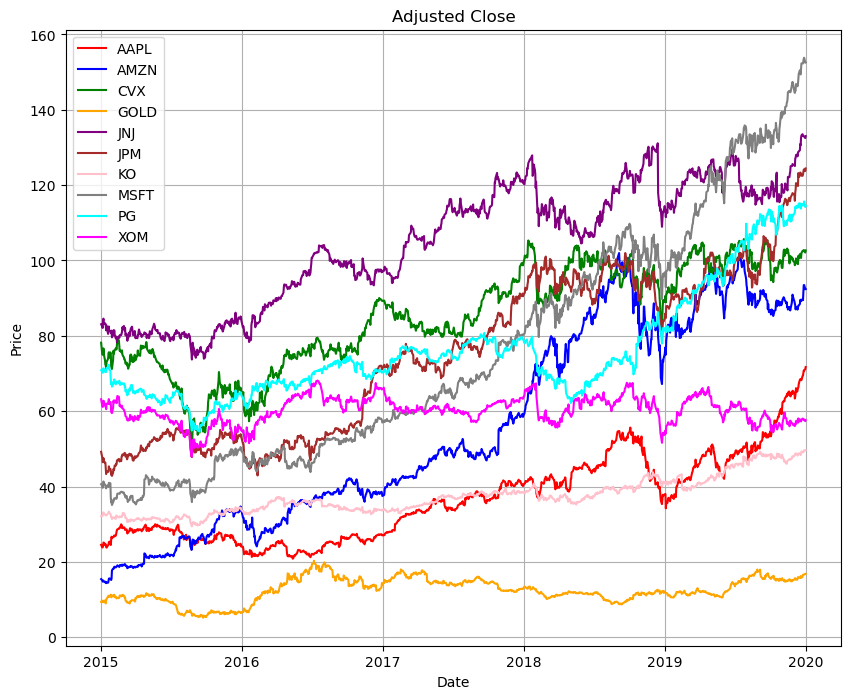

In [4]:
  # Set the figure size
plt.figure(figsize=(10, 8))

colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'cyan', 'magenta']

for i, column in enumerate(prices.columns):
    plt.plot(prices.index, prices[column], label=column, color = colors[i])

plt.title('Adjusted Close')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.savefig("prices.png", dpi=200)
plt.show()

#### Assigning random, equal weights for each asset

In [5]:

weights = np.array([0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1])


#### Calculate expected returns

We are using the **mean historical return Method**.

Other methods : 
- **Exponentially-weighted mean of (daily) historical returns**
- **Returns estimate using the Capital Asset Pricing Model**


In [6]:

mu = expected_returns.mean_historical_return(prices, compounding=True, frequency=252) 


#### Calculate the risk Model

We are going to use the **Sample Annualized Covariance Matrix**

Other risk models : 

- **Covariance Shrinkage Ledoit-Wolf.**
- **semicovariance matrix**
- **exponentially-weighted covariance matrix**
- **Oracle Approximating Shrinkage estimate**


In [7]:

S = sample_cov(prices, frequency=252)


#### Calculating the annual returns of the portfolio 

$$ R_p = \sum_{i=1}^{n}W_i Ri $$

##### Other important mathematical formulas : 

- Variance : 
$$ s^{2} = \frac{\sum_{i=1}^{N}(x_{i}-\bar{x})^2}{N-1} $$

- Standard Deviation : 
$$ s = \sqrt{\frac{\sum_{i=1}^{N}(x_{i}-\bar{x})^2}{N-1}} $$

- Covariance : 
$$ cov_{i,j}=\frac{\sum_{i=1, j =1}^{N}(x_{i}-\bar{x_{i}})(x_{j}-\bar{x_{j}})}{N-1} $$

- Correlation : 
$$ \rho(R_i,Rj) = \frac{COV(R_i,Rj)}{\sigma_{i} \sigma_{j}} $$

In [8]:
port_annual_ret = np.sum(returns.mean() * weights) * 252
port_annual_ret

0.1456220664852811

#### Portfolio Variance 

$$\sigma^2(Rp) = \sum_{i=1}^{n}\sum_{j=1}^{n} w_i w_j COV(R_i, R_j) $$

#### Portfolio standard deviation

$$ \sigma(R_p) = \sqrt{\sigma^2(R_p)} $$

In [9]:
port_variance = np.dot(weights.T, np.dot(S, weights))
port_variance

0.017788907936741944

In [10]:
port_volatility = np.sqrt(port_variance)
port_volatility

0.13337506489873563

#### Risk Free rate is 5%
#### Sharpe ratio : 
$$Sharpe = \frac{R_p - R_f}{\sigma_p}$$
with : $R_p$ : Portfolio expected return, $R_f$ : Risk free rate, $\sigma_p$ : Portfolio volatility/Standard deviation.

In [11]:
# Risk free rate = 5%
risk_free_rate = 0.05

sharpe_ratio = str(round((port_annual_ret - risk_free_rate)/port_volatility, 3))

# Performance of initial portfolio with 10% allocation for each Stock

percent_ret = str(round(port_annual_ret, 2)*100) + '%'
percent_vol = str(round(port_volatility, 2)*100) + '%'
percent_var = str(round(port_variance, 2)*100) + '%'

print ('Expected annual return :' + percent_ret)
print ('Annual Volatility / Risk :' + percent_vol)
print ('Annual Variance :' + percent_var)
print ('Sharpe Ratio :' + sharpe_ratio)

Expected annual return :15.0%
Annual Volatility / Risk :13.0%
Annual Variance :2.0%
Sharpe Ratio :0.717


In [12]:
# Minimum Volatility Portfolio

ef = EfficientFrontier(mu, S)
weights = ef.min_volatility()
cleaned_min_vol = ef.clean_weights()

print(cleaned_min_vol)
ef.portfolio_performance(verbose=True, risk_free_rate=0.05)

OrderedDict([('AAPL', 0.03361), ('AMZN', 0.01409), ('CVX', 0.0), ('GOLD', 0.06439), ('JNJ', 0.20249), ('JPM', 0.09089), ('KO', 0.35107), ('MSFT', 0.0), ('PG', 0.16546), ('XOM', 0.078)])
Expected annual return: 10.8%
Annual volatility: 11.4%
Sharpe Ratio: 0.51


(0.1080822459247089, 0.11398491820845053, 0.5095607983723837)

In [13]:
# Maximum Sharpe ratio with NO Constraints

ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe(risk_free_rate=0.05)
cleaned_no_const = ef.clean_weights()

print(cleaned_no_const)
ef.portfolio_performance(verbose=True, risk_free_rate=0.05)

OrderedDict([('AAPL', 0.0), ('AMZN', 0.5168), ('CVX', 0.0), ('GOLD', 0.08078), ('JNJ', 0.0), ('JPM', 0.17737), ('KO', 0.0), ('MSFT', 0.22505), ('PG', 0.0), ('XOM', 0.0)])
Expected annual return: 33.8%
Annual volatility: 20.8%
Sharpe Ratio: 1.38


(0.33774407454429933, 0.20834994364207124, 1.3810614464989774)

In [14]:
# Max Sharpe Ratio with constraints :
# 1) All weights should add up to 1
# 2) No shorting is allowed
# 3) L2_regularization in order to reduce the zero weights

ef = EfficientFrontier(mu, S)
ef.add_objective(L2_reg, gamma=2)
ef.add_constraint(lambda w : w[0] + w[1] + w[2] + w[3] + w[4] + w[5] + w[6] + w[7] + w[8] + w[9] == 1)
ef.add_constraint(lambda w : w >= 0)
weights = ef.max_sharpe(risk_free_rate=0.05)
cleaned_L2_reg = ef.clean_weights()

print(cleaned_L2_reg)
ef.portfolio_performance(verbose=False, risk_free_rate=0.05)

OrderedDict([('AAPL', 0.15684), ('AMZN', 0.32453), ('CVX', 0.0), ('GOLD', 0.06288), ('JNJ', 0.03816), ('JPM', 0.12983), ('KO', 0.03287), ('MSFT', 0.21376), ('PG', 0.04114), ('XOM', 0.0)])


(0.28794341141389274, 0.17968062418846437, 1.324257484570609)

- Performance of the portfolio that minimizes volatility :
Expected annual return: 10.8%
Annual volatility: 11.4%
Sharpe Ratio: 0.51
- Performance of the unconstrained portfolio that maximizes Sharpe ratio :
Expected annual return: 33.8%
Annual volatility: 20.8%
Sharpe Ratio: 1.38
- Performance of the portfolio that maximizes Sharpe ratio, with L2 regularization :
Expected annual return: 28.8%
Annual volatility: 18.0%
Sharpe Ratio: 1.32


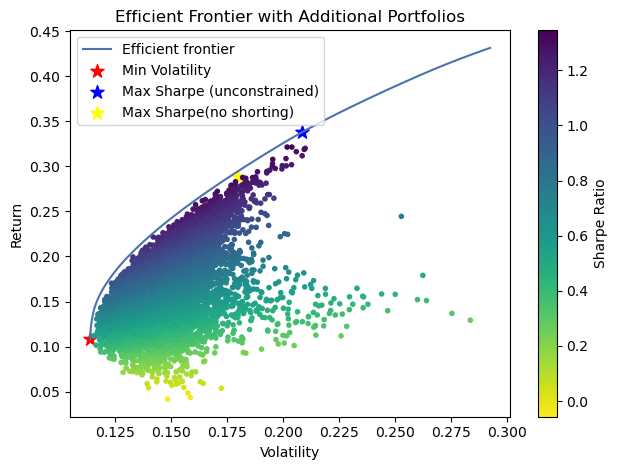

In [15]:
# Define the EfficientFrontier object
ef = EfficientFrontier(mu, S)
ef_constr = EfficientFrontier(mu, S, weight_bounds=(0,1))

# Portfolio that minimizes volatility
ef_min_volatility = ef.deepcopy()
weights_min_volatility = ef_min_volatility.min_volatility()
print("- Performance of the portfolio that minimizes volatility :")
ef_min_volatility.portfolio_performance(verbose=True, risk_free_rate=risk_free_rate)

# Portfolio with no constraints !!!
ef_no_const = ef.deepcopy()
weights_no_const = ef_no_const.max_sharpe(risk_free_rate=0.05)
print("- Performance of the unconstrained portfolio that maximizes Sharpe ratio :")
ef_no_const.portfolio_performance(verbose=True)

# Portfolio that maximizes Sharpe ratio with no shorting allowed + L2 regularization
ef_no_shorting = ef_constr.deepcopy()
ef_no_shorting.add_objective(L2_reg, gamma=2)
ef_no_shorting.add_constraint(lambda w : w[0] + w[1] + w[2] + w[3] + w[4] + w[5] + w[6] + w[7] + w[8] + w[9] == 1)
ef_no_shorting.add_constraint(lambda w : w >= 0)
weights_no_shorting = ef_no_shorting.max_sharpe(risk_free_rate=risk_free_rate)
print("- Performance of the portfolio that maximizes Sharpe ratio, with L2 regularization :")
ef_no_shorting.portfolio_performance(verbose=True)

# Plot the efficient frontier with the portfolios
fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

# Plot the portfolio that minimizes volatility
ret_vol, std_vol, _ = ef_min_volatility.portfolio_performance()
ax.scatter(std_vol, ret_vol, marker="*", s=100, c="r", label="Min Volatility")

# Plot the portfolio with no constraints 
ret_no_const, std_no_const, _ = ef_no_const.portfolio_performance()
ax.scatter(std_no_const, ret_no_const, marker="*", s=100, c="blue", label="Max Sharpe (unconstrained)")

# Plot the portfolio that maximizes Sharpe ratio with no shorting allowed
ret_shorting, std_shorting, _ = ef_no_shorting.portfolio_performance()
ax.scatter(std_shorting, ret_shorting, marker="*", s=100, c="Yellow", label="Max Sharpe(no shorting)")

# Generate random portfolios
n_samples = 10000
w_random = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
rets_random = w_random.dot(ef.expected_returns)
stds_random = np.sqrt(np.diag(w_random @ ef.cov_matrix @ w_random.T))
sharpes_random = (rets_random - risk_free_rate) / stds_random
sc = ax.scatter(stds_random, rets_random, marker=".", c=sharpes_random, cmap="viridis_r")

# Output
cbar = plt.colorbar(sc)
cbar.set_label('Sharpe Ratio')

ax.set_title("Efficient Frontier with Additional Portfolios")
ax.legend()
plt.tight_layout()
plt.savefig("ef_scatter.png", dpi=200)
plt.show()

In [16]:
weights_portfolio1 = [('AAPL', 0.03361), ('AMZN', 0.01409), ('CVX', 0.0), ('GOLD', 0.06439), ('JNJ', 0.20249), 
                      ('JPM', 0.09089), ('KO', 0.35107), ('MSFT', 0.0), ('PG', 0.16546), ('XOM', 0.078)]

weights_portfolio2 = [('AAPL', 0.0), ('AMZN', 0.5168), ('CVX', 0.0), ('GOLD', 0.08078), ('JNJ', 0.0), 
                      ('JPM', 0.17737), ('KO', 0.0), ('MSFT', 0.22505), ('PG', 0.0), ('XOM', 0.0)]

weights_portfolio3 = [('AAPL', 0.15684), ('AMZN', 0.32453), ('CVX', 0.0), ('GOLD', 0.06288), ('JNJ', 0.03816), 
                      ('JPM', 0.12983), ('KO', 0.03287), ('MSFT', 0.21376), ('PG', 0.04114), ('XOM', 0.0)]

# Create a DataFrame for each portfolio
df_portfolio1 = pd.DataFrame(weights_portfolio1, columns=['Ticker', 'Min_Volatility']).set_index('Ticker')
df_portfolio2 = pd.DataFrame(weights_portfolio2, columns=['Ticker', 'Unconstrained']).set_index('Ticker')
df_portfolio3 = pd.DataFrame(weights_portfolio3, columns=['Ticker', 'L2 Regularization']).set_index('Ticker')

# Concatenate the DataFrames
portfolio_weights = pd.concat([df_portfolio1, df_portfolio2, df_portfolio3], axis=1)

print(portfolio_weights)

        Min_Volatility  Unconstrained  L2 Regularization
Ticker                                                  
AAPL           0.03361        0.00000            0.15684
AMZN           0.01409        0.51680            0.32453
CVX            0.00000        0.00000            0.00000
GOLD           0.06439        0.08078            0.06288
JNJ            0.20249        0.00000            0.03816
JPM            0.09089        0.17737            0.12983
KO             0.35107        0.00000            0.03287
MSFT           0.00000        0.22505            0.21376
PG             0.16546        0.00000            0.04114
XOM            0.07800        0.00000            0.00000


## Comments :

Based on these results, we can conclude that : 

- **Comment 1**:  The Min_Volatility portfolio allocates a non-zero weight to AAPL, AMZN, GOLD, JNJ, JPM, MSFT, and PG. With only 2 zero allocations for CVX and MSFT respectively, which makes it a more **diversified portfolio** than the **unconstrained portfolio**. Therefore, it reduce the impact of any individual security's performance on the overall portfolio.


- **Comment 2**: The Unconstrained portfolio has **zero weights** for AAPL, CVX, JNJ, KO, PG and XOM. It appears to have a **higher allocation** to AMZN (51.68%), MSFT (22.5%) and JPM (17.73%) compared to the Min_Volatility portfolio. Therefore, it increases the impact of any individual security's performance on the overall portfolio **(more concentrated).**


- **Comment 3**: The L2 regularization portfolio demonstrates a notable improvement by reducing the number of zero weights (only 2 zero weights), which indicates a more balanced allocation of investments across the portfolio. This regularization technique penalizes extreme weightings, encouraging a more even distribution of investments across the portfolio. This can lead to improved risk management and stability while still allowing for the potential for attractive returns.

### Future Works : 

In this work, we worked with the Mean-Variance optimization technique. Note that there are several other optimization techniques used in portfolio management beyond mean-variance optimization. for example : 
#### The Black-Litterman (BL) model
#### Hierarchical Risk Parity

In future work, we plan to expand our portfolio optimization projects to include the **hierarchical risk parity model** and the **Black-Litterman model**, as well as applying the optimization techniques without the use of any external library. 

These additional techniques will further enhance our portfolio management capabilities and allow us to capture additional insights and benefits.

## References :

### Biblio

- Stewart, S. D., Piros, C. D., & Heisler, J. C. (2019). Portfolio Management: Theory and Practice. John Wiley & Sons.
- Brugière, P. (2020). Quantitative Portfolio Management with applications in Python. In Springer texts in business and economics. Springer International Publishing.
- PyPortfolioOpt documentation.

### Web :

- Various YouTube channels.
- GitHub Repos.
- And of course, StackOverflow.